LAB6-12S.tif.gz rb fabio.<gzip _io.BufferedReader name='LAB6-12S.tif.gz' 0x204e54826e0>
Initial center from RANSAC: [1152.18038521 3055.59250634]
First arc radius: 1379.8877749702247


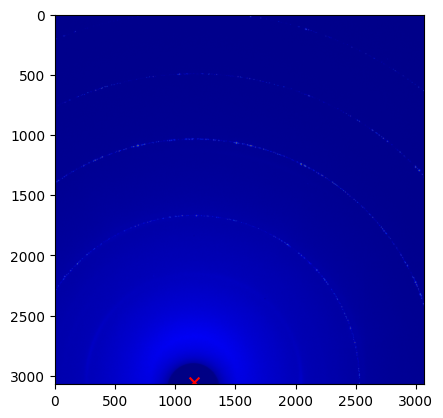

In [4]:
import numpy as np
import fabio
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

def simple_kmeans(data, n_clusters, max_iters=20):
    """一维K-Means聚类"""
    centers = np.random.choice(data, size=n_clusters, replace=False)
    for _ in range(max_iters):
        distances = np.abs(data[:, None] - centers)
        labels = np.argmin(distances, axis=1)
        new_centers = np.array([data[labels == i].mean() if np.any(labels == i) else centers[i] 
                              for i in range(n_clusters)])
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    return labels, centers

def evaluate_center(distances, n_clusters, threshold):
    labels, centers_k = simple_kmeans(distances, n_clusters)
    inlier_count = np.sum(np.abs(distances - centers_k[labels]) < threshold)
    return inlier_count, centers_k

def ransac_center_optimized(points, num_iterations=500, threshold=5, n_clusters=5):
    # 计算所有候选中心（如上所述）
    indices = np.random.choice(len(points), (num_iterations, 3), replace=False)
    pts = points[indices]
    pt1, pt2, pt3 = pts[:, 0, :], pts[:, 1, :], pts[:, 2, :]
    mid1 = (pt1 + pt2) / 2
    dir1 = np.stack((pt2[:, 1] - pt1[:, 1], pt1[:, 0] - pt2[:, 0]), axis=1)
    mid2 = (pt2 + pt3) / 2
    dir2 = np.stack((pt3[:, 1] - pt2[:, 1], pt2[:, 0] - pt3[:, 0]), axis=1)
    A = np.empty((num_iterations, 2, 2))
    A[:, :, 0] = dir1
    A[:, :, 1] = -dir2
    b = mid2 - mid1
    det = A[:, 0, 0] * A[:, 1, 1] - A[:, 0, 1] * A[:, 1, 0]
    valid = np.abs(det) > 1e-8
    t = np.full(num_iterations, np.nan)
    t[valid] = (A[valid, 1, 1] * b[valid, 0] - A[valid, 0, 1] * b[valid, 1]) / det[valid]
    centers = mid1 + t[:, None] * dir1
    valid_centers = centers[valid]
    
    # 计算距离矩阵
    distances = np.linalg.norm(points[:, None, :] - valid_centers[None, :, :], axis=2)
    
    # 并行执行 K-means 和内点统计
    results = Parallel(n_jobs=-1)(delayed(evaluate_center)(distances[:, i], n_clusters, threshold) 
                                  for i in range(distances.shape[1]))
    
    # 找到最佳结果
    inlier_counts, centers_k_list = zip(*results)
    best_idx = np.argmax(inlier_counts)
    best_center = valid_centers[best_idx]
    best_centers_k = centers_k_list[best_idx]
    return best_center, best_centers_k

def adaptive_threshold(arr):
    max_val = np.max(arr)
    max_count = np.count_nonzero(arr == max_val)

    if max_count > 50: # mask gap
        arr[arr == max_val] = 0

    num_points = arr.shape[0] + arr.shape[1]
    top_indices = np.argsort(arr.flatten())[-num_points:]
    mask = np.zeros_like(arr, dtype=bool)
    row_indices, col_indices = np.unravel_index(top_indices, arr.shape)
    mask[row_indices, col_indices] = True
    mask2 = arr > 0
    result_array = arr * mask * mask2
    return result_array

data= 'LAB6-12S.tif.gz'
image = fabio.open(data).data
thresh = adaptive_threshold(image)
y_coords, x_coords = np.where(thresh > 0)
points = np.column_stack((x_coords, y_coords))

# 获取圆心和聚类半径
initial_center, best_centers_k = ransac_center_optimized(points, n_clusters=4)
# 按升序排列半径并取第一个（最小半径）
sorted_radii = np.sort(best_centers_k)
first_radius = sorted_radii[0]

print("Initial center from RANSAC:", initial_center)
print("First arc radius:", first_radius)

plt.imshow(image, cmap='jet', clim=(0,1500))
plt.scatter(initial_center[0], initial_center[1], c='red', marker='x', s=50)
plt.show()